<a href="https://colab.research.google.com/github/yajima-yasutoshi/DataMining2024/blob/main/20241224/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機会学習

## 20241224

#本日の講義の目的

機械学習による分類手法に関する説明を行う。
ここでは、代表的な手法である
**決定木**および**ランダムフォレスト**
と呼ばれる2つの分類モデルの構築法を理解する。

なお、決定木やランダムフォレストは2クラス（2値）の分類だけでなく、
3クラス以上の一般のカテゴリ分類や、数値予測にも適応が可能である。

利用するモジュールは以下のようになる。


アルゴリズム(AI) | カテゴリ予測 | 数値予測
-- | -- | --
重回帰 | - | from sklearn.linear_model import LinearRegression
ロジスティック回帰 | from sklearn.linear_model import LogisticRegression | -
決定木  | from sklearn.tree import DecisionTreeClassifier | from sklearn.tree import DecisionTreeRegressor
ランダムフォレスト | from sklearn.ensemble import RandomForestClassifier | from sklearn.ensemble import RandomForestRegressor


### 【参考】

*  決定木ライブラリー

 https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier


* ランダムフォレストライブラリー

 https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


# 準備


## 必要なライブラリーのインポート

In [ ]:
# インストール
!pip install japanize-matplotlib

# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV

# 決定木に必要なライブラリー
from sklearn.tree import DecisionTreeClassifier, plot_tree

# ランダムフォレストに必要なライブラリー
from sklearn.ensemble import RandomForestClassifier

# その他必要なライブラリー
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 24.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=a8791363fa31986a140d1f3ba1fc61dfd1249b6d50875b2986d3b68858950f94
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


# Cancerデータを使った例

## データ

sklean ライブラリーに格納されているサンプルデータ（cancer data）を使い
**決定木**の説明を行う。

まず、データを読み込む。

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
df['diagnosis'] = cancer.target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

これは、30項目の細胞に関連したデータ（サイズ、形状、など）と
そこから判断された癌の診断結果（'diagnosis'）のデータである。

全ての項目は数値型で、
特に診断結果（'diagnosis'）は

* 悪性の場合には 0
* 良性の場合には 1

が入力されており、
このような項目を**2値**の項目と呼ぶ。

このデータを学習させて、
細胞に関する30項目を説明変数として
**癌の診断（良性か悪性かの分類）を行うAIを構築**する。

### 基礎集計

In [ ]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


diagnosis は数値型の項目ではあるが、値は 0 と 1 の2値となっていることが確かめられる。


In [ ]:
df['diagnosis'].value_counts()

,count
diagnosis,
1,357
0,212


ヒストグラムを作成して、各項目の分布を確認する。
hue を使いdiagnosisで色分けしてみる

<Axes: xlabel='mean radius', ylabel='Count'>

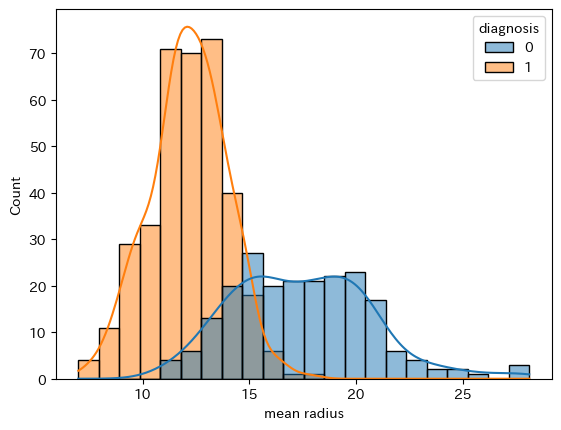

In [ ]:
sns.histplot(data=df, x='mean radius', hue='diagnosis', kde=True)

このグラフからは、mean radius がおよそ18をこえるとほぼ全てが悪性、
逆に10を下回るとほぼ全てが良性になっていることが分かる。

一方で、10から18の間では、良性も悪性もあり、この項目だけでは
悪性か良性かを判断できないことが分かる。

# 決定木
30項目の数値データと癌の診断結果（diagnosis）から、
悪性か良性かを分類するAIを構築する。

悪性か良性かといった分類問題に対する代表的な機械学習の手法として、
**「決定木」**の使い方を説明する。

## 変数

今までの予測と同様に、説明変数と目的変数を定める。

* **説明変数：** 予測する元になる項目。上のデータでは30項目の数値型データがある。
* **目的変数：** 予測の対象となる項目。上のデータでは diagnosis である。

なお、決定木の場合には、**説明変数の標準化は不要である**。


説明変数と目的変数をそれぞれ別の変数（X と y）にセットする。

In [ ]:
# 項目'diagnosis'は変数dfの最後にある項目なので、それを除くと説明変数のみとなる
X = df.iloc[:,:-1]
y = df[['diagnosis']]

In [ ]:
# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split

# データを学習用データと検証用データに分割
# test_size は、0.2 から 0.3 程度が良いとされる
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

##決定木モデルを学習する

In [ ]:
# 決定木に必要なライブラリー
from sklearn.tree import DecisionTreeClassifier

# 決定木のインスタンスを作成
model = DecisionTreeClassifier(max_depth=2, random_state=0)

# 学習
model.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(max_depth=2, random_state=0)

決定木の内部では、以下の図に示すような
予測がモデルが構築される。

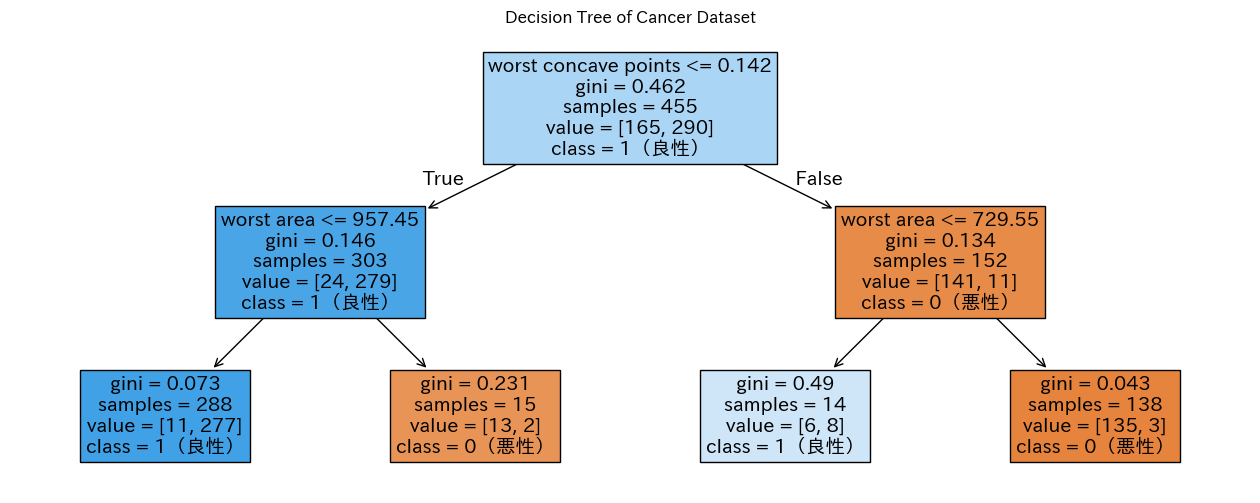

In [ ]:
# 決定木を可視化する
plt.figure(figsize=(16,6))
plot_tree(model, filled=True, feature_names=cancer.feature_names, class_names=['0（悪性）','1（良性）'], fontsize=14)
plt.title("Decision Tree of Cancer Dataset")
plt.show()

決定木モデルでは、説明変数の値の大小で
上の図のように枝分かれしながら予測が行われる。
上の図の場合は
max_depth=2 と指定したので、
2回枝分かれをするモデルになっている。
データが不等式の条件を満たせば左、満たさない場合は右方向に枝を下方向に
たどりながら、最後に到達した箱の class が予測結果である。

上の場合では、枝分かれに用いられた項目は
worst concave points
と
worst area
の2つであった。
この二つが目的変数（この例では良性か悪性か）の判断に有効である、
との結果になったことを意味している。

例えば、ある細胞のデータが、

* worst concave points = 0.2
* worst area = 700

であった場合、予測結果は class=1 (良性)と判定される。





In [ ]:
sns.histplot(data=df, x='worst concave points', hue='diagnosis', kde=True)

In [ ]:
sns.histplot(data=df, x='worst area', hue='diagnosis', kde=True)

In [ ]:
sns.jointplot(x='worst concave points', y='worst area', data=df, hue='diagnosis')

### 評価用のデータを使い予測精度を確認する

In [ ]:
# テストデータで予測
y_pred = model.predict(X_val)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9649122807017544


混同行列（confusion matrix）でも確認する。

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[44,  3],
       [ 1, 66]])

# Titanic データを使った例（決定木）

In [ ]:
# データを読み込む
data = sns.load_dataset("titanic") #タイタニックのデータ
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


##データの説明

列名 | 意味
---  | ---
survived	| 生存フラグ（0=死亡、1=生存）
pclass	| チケットクラス（1stクラス、2ndクラス、3rdクラス）
sex	| 性別（male=男性、female＝女性）
sge	| 年齢
sibsp	| タイタニックに同乗している兄弟/配偶者の数
parch	| タイタニックに同乗している親/子供の数
fare	| 料金
embarked	| 出港地（タイタニックへ乗った港）(C=Cherbourg、Q=Queenstown、S=Southampton)
class | 乗船クラス
who |男性 or 女性
adult_male | 成人男性であるかどうか
deck | 乗船していたデッキ
embark_town | 出港地
alive | 生存したかどうか
alone | 一人であったかどうか

In [ ]:
# 欠損値を埋める
data['age'].fillna(data['age'].mean(), inplace=True)
data['embarked'].fillna(data['embarked'].mode()[0], inplace=True)
data['embark_town'].fillna(data['embark_town'].mode()[0], inplace=True)
# 結果を確認
data.isnull().sum()

<ipython-input-13-68a392a7bcd8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(data['age'].mean(), inplace=True)
<ipython-input-13-68a392a7bcd8>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

,0
survived,0
pclass,0
sex,0
age,0
sibsp,0
parch,0
fare,0
embarked,0
class,0
who,0


In [ ]:
# カテゴリ変数をOne Hot Encoding
data_encoded = pd.get_dummies(data[['sex', 'embarked', 'class', 'who', 'adult_male', 'alone']], drop_first=True)

# 説明変数と目的変数を設定
X = pd.concat([data[['age', 'fare', 'sibsp', 'parch']], data_encoded], axis=1)
y = data['survived']

ハイパーパラメータの max_depth を 2 として決定木を作る。

In [ ]:
# データを訓練セットとテストセットに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 最適なモデルを作成
model = DecisionTreeClassifier(max_depth=2, random_state=0)
model.fit(X_train, y_train.values.ravel())

# 検証用データで予測
y_pred = model.predict(X_val)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.776536312849162


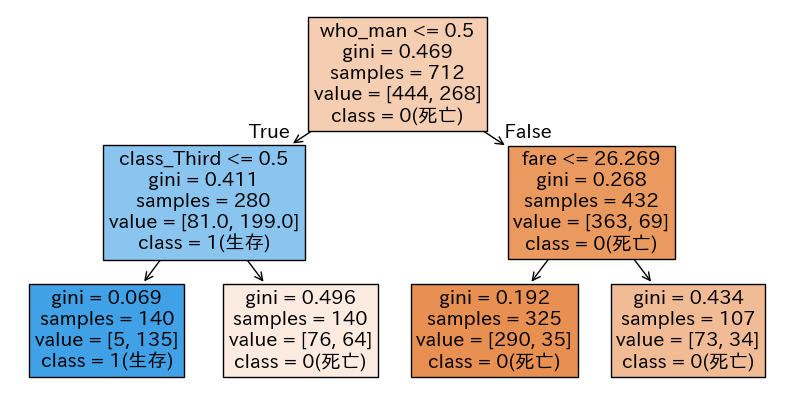

In [ ]:
# 決定木を可視化する
plt.figure(figsize=(10,5))
plot_tree(model, filled=True,  fontsize=14, feature_names=X.columns[:-1], class_names=['0(死亡)','1(生存)'])
plt.show()

一番上の who_man は、カテゴリ項目 who を One hot encoding した項目で、
who の値が man であれば 1 、そうでないなら 0 になっている。

who_man <= 0.5 という不等式なので、0 （すなわち man でない）ならば左側に、
1 ならば右側に枝分かれする。

例えば、
* who = woman
* class = Third
の場合は「死亡」と予測されることになる。


### ハイパーパラメータチューニング

決定木のハイパーパラメータは max_depth である。
max_depth を 2から20の範囲で
以下のようにグリッドサーチを行う。


In [ ]:
from sklearn.model_selection import GridSearchCV

# ハイパーパラメータの候補
param_grid = {
    'max_depth': [2, 3, 4, 5, 10, 20]
    }

# グリッドサーチで最適なハイパーパラメータを探す
grid_search = GridSearchCV( DecisionTreeClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 10, 20]})

最適なパラメータは grid_search.best_estimator_ にセットされる。

In [ ]:
grid_search.best_params_

{'max_depth': 3}

In [ ]:

# 最適なモデルを作成
model = grid_search.best_estimator_
model.fit(X_train, y_train.values.ravel())

# テストデータで予測
y_pred = model.predict(X_val)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8100558659217877


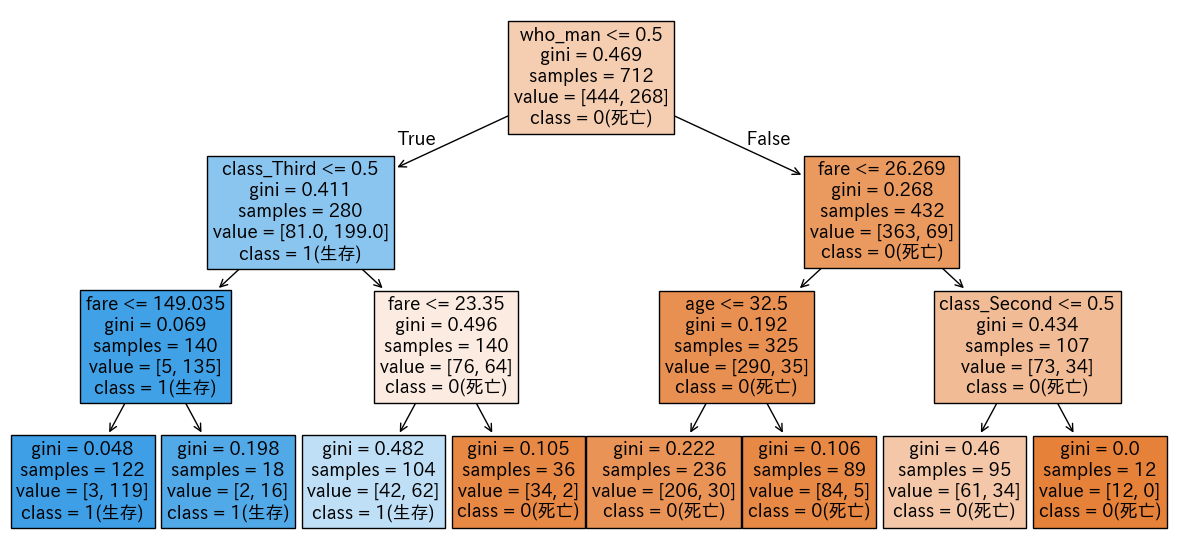

In [ ]:
# 決定木を可視化する
plt.figure(figsize=(15,7))
plot_tree(model, filled=True,  fontsize=13, feature_names=X.columns[:-1], class_names=['0(死亡)','1(生存)'])
plt.show()

---
---
---


# ランダムフォレスト
分類問題に対する代表的な機械学習の手法として、
**「ランダムフォレスト」**の使い方を説明する。

ランダムフォレストは、決定木を複雑に組み合わせた構造を持ち、
高い予測精度となるように工夫されてる。
決定木と同様に、カテゴリ型の予測だけでなく
数値型の予測も行える高精度な万能な予測手法である。
ビジネスでも多く用いられている手法である。

ただし、決定木のように予測の内部構造を可視化することができない。
また、ランダムフォレストを利用するためには、
複数のハイパーパラメータの調整が必要で、
他の機械学習法と比べて多くの計算時間を必要とする。


##ランダムフォレストモデルを学習する

学習を行う関数は、今までと同様で fit であり、
以下のように用いる

```
model = RandomForestClassifier()
model.fit(説明変数, 目的変数)
```

である。

Titanic Data を使い学習を行い検証用のデータで精度を評価する。

In [ ]:
# ランダムフォレストに必要なライブラリー
from sklearn.ensemble import RandomForestClassifier

# ランダムフォレストのインスタンスを作成
model = RandomForestClassifier()

# 学習
model.fit(X_train, y_train.values.ravel())

In [ ]:
from sklearn.metrics import accuracy_score

# 評価データで予測
y_pred = model.predict(X_val)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
accuracy

ランダムフォレストでは、説明変数の重要度を表示できる。
値が大きいほど、予測精度に寄与する度合いが大きいことを意味している。
重要度の小さな変数を用いなくてもほとんど精度に影響がない、
逆に重要度の大きな変数を用いない場合は精度が悪化する。

重要度の値は全て正となり、回帰係数とは異なる意味合いの物である。

In [ ]:
model.feature_importances_

In [ ]:
# 特徴量の重要度を可視化
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.show()

## ハイパーパラメータチューニング

ランダムフォレストを利用するためには、
いくつかのハイパーパラメータを適切に設定する必要がある。
上の例ではデフォルト値が用いられているが、
変更することでより精度を向上させることが可能である。

調整することで精度の向上が期待できるパラメーターには以下のものがある。

*  n_estimators（木の数）: 10 ～ 1000 程度
*  max_depth（木の深さ） : 3 ～ 100 程度
*  min_samples_split（分割の最小のサンプル数）: 2 ～ 100 程度

In [ ]:
# ランダムフォレストに必要なライブラリー
from sklearn.ensemble import RandomForestClassifier

# ハイパーパラメータの候補
param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [3, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10]
}

# グリッドサーチで最適なハイパーパラメータを探す
grid_search = GridSearchCV( RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train.values.ravel())

# 最適なハイパーパラメータを出力
print("Best Parameters: ", grid_search.best_params_)

# 最適なモデルを作成
model = grid_search.best_estimator_

# 学習
model.fit(X_train, y_train.values.ravel())


## 精度の評価

評価用のデータセットを用いて精度の評価を行う。


In [ ]:
from sklearn.metrics import accuracy_score

# 評価データで予測
y_pred = model.predict(X_val)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
accuracy

検証用データの場合で、混同行列を作成する。

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

---
---
---


# Iris データを使った例

## データ

アイリスデータセットには、
3種類のアイリス花（セトサ、バーシクル、バージニカ）各50レコード
の計150レコードが記録されている。

各項目は以下の通り

項目名 | 型 | 説明
--  | -- | --
Petal Length | 数値 | 花びらの長さ
Petal Width  | 数値 | 花びらの幅
Sepal Length | 数値 | がく片の長さ
Sepal Width | 数値 | がく片の幅
species     | カテゴリ | 花の種類（セトサ、バーシクル、バージニカ）

花びらの長さなど4つの項目から花の種類を予測するAIを作る。

In [ ]:
# seabornからデータをロードする
df = sns.load_dataset('iris')
df.info()
df.head()

## 決定木を使った花の種類の予測

In [ ]:
# 特徴量とラベルを分ける
X = df.drop('species', axis=1)
y = df['species']

# データを学習セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 決定木のインスタンスを作成
model = DecisionTreeClassifier(max_depth=2)

# 学習
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# 精度を計算
print("Accuracy: ", accuracy_score(y_test, y_pred))


## 決定木を可視化する

決定木モデルの枝分かれの様子を可視化する

In [ ]:
# 決定木を可視化する
plt.figure(figsize=(10,5))
plot_tree(model, filled=True,  fontsize=12, feature_names=df.columns[:-1], class_names=df['species'].unique() )
plt.show()

In [ ]:
# 特徴量とラベルを分ける
X = df.drop('species', axis=1)
y = df['species']

# データを学習セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 決定木のインスタンスを作成
model = DecisionTreeClassifier(max_depth=2)

# 学習
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# 精度を計算
print("Accuracy: ", accuracy_score(y_test, y_pred))


# ハイパーパラメータの候補
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# グリッドサーチで最適なハイパーパラメータを探す
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータを出力
print("Best Parameters: ", grid_search.best_params_)

# 最適なモデルを取得
best_rf = grid_search.best_estimator_

# 学習
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

# 特徴量の重要度を可視化
feature_importances = best_rf.feature_importances_
sns.barplot(x=feature_importances, y=X.columns)
plt.title('Feature Importances')
plt.show()




---



---

